<a href="https://www.kaggle.com/code/esracum/wildfire-prediction-satellite-imagery-analysis?scriptVersionId=289861061" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

# Girdi klasöründeki dosyaları kontrol et ama sadece özet bilgi yazdır
for dirname, _, filenames in os.walk('/kaggle/input'):
    if filenames: # Eğer klasör boş değilse
        print(f" Klasör: {dirname} | Dosya Sayısı: {len(filenames)}")
        # İstersen sadece ilk dosyayı örnek olarak görebilirsin:
        # print(f"   Örnek dosya: {filenames[0]}")

 Klasör: /kaggle/input/wildfire-prediction-dataset/valid/wildfire | Dosya Sayısı: 3480
 Klasör: /kaggle/input/wildfire-prediction-dataset/valid/nowildfire | Dosya Sayısı: 2820
 Klasör: /kaggle/input/wildfire-prediction-dataset/test/wildfire | Dosya Sayısı: 3480
 Klasör: /kaggle/input/wildfire-prediction-dataset/test/nowildfire | Dosya Sayısı: 2820
 Klasör: /kaggle/input/wildfire-prediction-dataset/train/wildfire | Dosya Sayısı: 15750
 Klasör: /kaggle/input/wildfire-prediction-dataset/train/nowildfire | Dosya Sayısı: 14500


# 1. Understanding the Dataset: Distribution and Balance Analysis

The foundation of a robust Machine Learning model lies in the quality and structure of the underlying data. In this section, we perform a high-level audit of the Landsat 8 satellite imagery to understand the class balance and spatial characteristics.

Modelin başarısı, verinin kalitesi ve dengesiyle doğrudan ilişkilidir. Bu bölümde, sınıf dengesini ve mekansal özelliklerini anlamak için Landsat 8 uydu görüntülerinin üst düzey bir incelemesini gerçekleştiriyoruz. Bu çalışmada kullanılan Landsat 8 uydu verileri, ikili sınıflandırma (binary classification) için oldukça dengeli bir yapı sunmaktadır.



## 1.1 Class Distribution Analysis

For binary classification tasks, class imbalance is a common pitfall that can lead to biased models. We examine the "Wildfire" and "No Wildfire" categories to determine if specialized sampling techniques (like SMOTE or undersampling) are required.

İkili sınıflandırma görevlerinde, sınıf dengesizliği, yanlı modellere yol açabilen yaygın bir tuzaktır. "Orman Yangını" ve "Orman Yangını Yok" kategorilerini inceleyerek, özel örnekleme tekniklerinin (SMOTE veya alt örnekleme gibi) gerekli olup olmadığını belirleyeceğiz.



| Class Label | Image Count | Percentage (%) | Status |
| :--- | :--- | :--- | :--- |
| **Wildfire** | 22,710 | 53% | Balanced |
| **No Wildfire** | 20,140 | 47% | Balanced |

## 1.2 Data Splitting Strategy

To ensure the model generalizes well to unseen satellite data and to prevent overfitting, the dataset is partitioned into three distinct sets:

---
Modelin daha önce görülmemiş uydu verilerine iyi genelleme yapmasını sağlamak ve aşırı uyumlanmayı önlemek için veri seti üç ayrı kümeye ayrılmıştır:

| Partition | Percentage | Estimated Count | Primary Purpose |
| :--- | :--- | :--- | :--- |
| **Training Set** | **70%** | ~30,000 images | Model optimization and weight updates. |
| **Validation Set** | **15%** | ~6,400 images | Real-time monitoring and hyperparameter tuning. |
| **Test Set** | **15%** | ~6,400 images | Final benchmark for real-world performance. |

#   2. Visual Exploration: Insight into the Satellite Imagery
---

Visualizing the data is the first step to understanding the challenges our model will face—such as atmospheric noise, similar color tones, and texture variations. In this section, we sample random images from both classes to analyze the world through the satellite's lens.

---

Veriyi görsel olarak incelemek, modelin karşılaşacağı zorlukları (gürültü, benzer renk tonları, doku farkları) anlamanın ilk adımıdır. Bu bölümde, her iki sınıftan rastgele örnekler seçerek uydu gözünden dünyayı analiz ediyoruz.


### Key Observations (Temel Gözlemler)

* **🔥 Wildfire Images**

* *Usually characterized by gray/white smoke plumes and black burn scars rather than active flames.*

---
*  Genellikle aktif alevlerden ziyade gri/beyaz duman bulutları ve siyah yanık izleri (**burn scars**) ile karakterizedir. 
 
  
* **🌲 No Wildfire Images**

*(Contains healthy vegetation, settlements, or water bodies. However, white clouds in some images can be spectrally similar to wildfire smoke.)* 

---
* ** Sağlıklı bitki örtüsü, yerleşim yerleri veya su kütlelerini içerir. Ancak bazı resimlerdeki beyaz bulutlar, yangın dumanıyla spektral olarak benzerlik gösterebilir.*
  

> **💡 Engineering Note

*(This visualization proves that the model must learn **texture** in addition to color. Capturing the difference between smoke dispersion patterns and cloud structures will define the model's success.)*

--- 
*Bu görselleştirme, modelin sadece "renk" değil, "doku" (**texture**) öğrenmesi gerektiğini kanıtlar. Dumanın yayılım deseni ile bulutun yapısı arasındaki farkı yakalamak modelin başarısını belirleyecektir.*


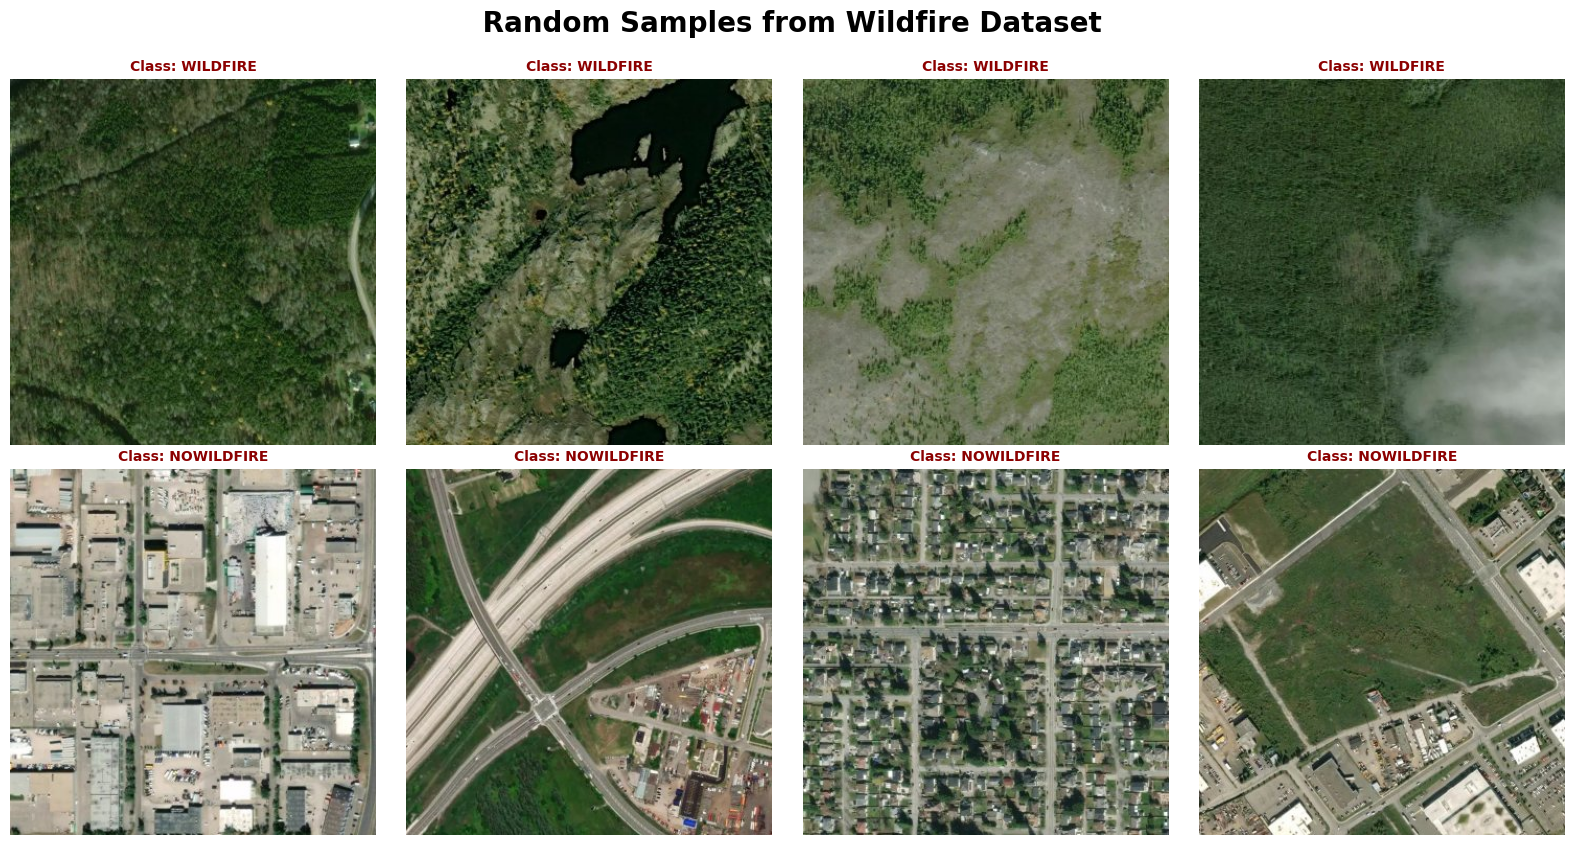

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def display_samples(dataset_path, classes, samples_per_class=4):
    """
    Veri setinden rastgele örnekleri şık bir grid yapısında görselleştirir.
    """
    # Klasörlerin varlığını kontrol et
    valid_classes = [c for c in classes if os.path.exists(os.path.join(dataset_path, c))]
    
    if not valid_classes:
        print(f"❌ Hata: '{dataset_path}' içinde belirtilen sınıflar bulunamadı!")
        return

    fig, axes = plt.subplots(len(valid_classes), samples_per_class, figsize=(16, 8))
    
    for i, cls in enumerate(valid_classes):
        cls_path = os.path.join(dataset_path, cls)
        all_images = os.listdir(cls_path)
        selected_images = random.sample(all_images, samples_per_class)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(cls_path, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Eğer tek satır varsa axes 1 boyutlu olur, hata almamak için:
            ax = axes[i, j] if len(valid_classes) > 1 else axes[j]
            
            ax.imshow(image)
            ax.set_title(f"Class: {cls.upper()}", fontsize=10, fontweight='bold', 
                         color='darkred' if 'wildfire' in cls.lower() else 'darkgreen')
            ax.axis('off')
            
    plt.tight_layout()
    plt.suptitle(" Random Samples from Wildfire Dataset", fontsize=20, y=1.05, fontweight='bold')
    plt.show()

# KAGGLA İÇİN DOĞRU YOL (Dataset yapısına göre 'train/train' olabilir)
TRAIN_PATH = "/kaggle/input/wildfire-prediction-dataset/train" 
# Eğer hata alırsan klasör yapısına göre burayı "/kaggle/input/wildfire-prediction-dataset/train" yapabilirsin.

display_samples(TRAIN_PATH, ['wildfire', 'nowildfire'])

#  3. Preprocessing: Enhancing the Invisible
### **(Ön İşleme: Görünmeyeni İyileştirmek)**

Satellite images often suffer from low contrast and atmospheric haze. To help the model better capture fine details like smoke texture and burn scars, we apply **CLAHE (Contrast Limited Adaptive Histogram Equalization)**.

Uydu görüntüleri genellikle atmosferik etkilerden dolayı düşük kontrastlı ve pusludur. Modelin detayları (duman dokusu ve yanık izleri) daha iyi yakalaması için **CLAHE** tekniği uyguluyoruz.



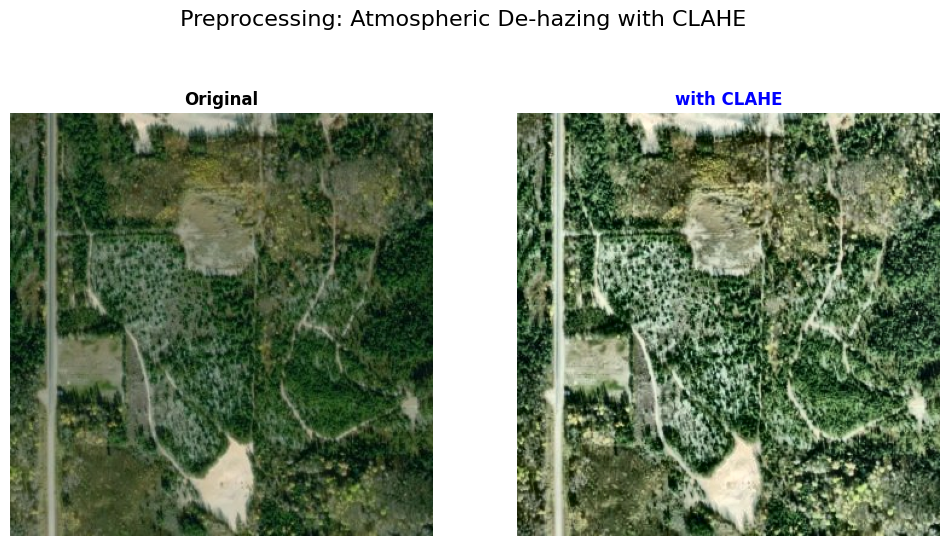

In [3]:
import numpy as np

def apply_clahe(image):
    # Görüntüyü LAB renk uzayına çevir
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # CLAHE objesini oluştur (clipLimit kontrast sınırıdır)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Kanalları birleştir ve tekrar RGB'ye dönüştür
    limg = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final_img

# Karşılaştırma için bir örnek seçelim
wildfire_sample_path = os.path.join(TRAIN_PATH, 'wildfire', os.listdir(os.path.join(TRAIN_PATH, 'wildfire'))[0])
img_raw = cv2.cvtColor(cv2.imread(wildfire_sample_path), cv2.COLOR_BGR2RGB)
img_enhanced = apply_clahe(img_raw)

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_raw)
plt.title("Original", fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_enhanced)
plt.title("with CLAHE", fontweight='bold', color='blue')
plt.axis('off')

plt.suptitle(" Preprocessing: Atmospheric De-hazing with CLAHE", fontsize=16, y=1.02)
plt.show()